## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Dividing dataset and saving to files

In [31]:
df = pd.read_csv('heart_disease_patients.csv')

# Split data into train and remaining data
X_train, X_remaining = train_test_split(df, test_size=0.3, random_state=42)

# Split remaining data into test and validation sets
X_test, X_validation = train_test_split(X_remaining, test_size=0.5, random_state=42)

train_df = pd.DataFrame(X_train) 
train_df.to_csv('train.csv', index=False)

test_df = pd.DataFrame(X_test)  
test_df.to_csv('test.csv', index=False)

validation_df = pd.DataFrame(X_validation)
validation_df.to_csv('validation.csv', index=False)


## Data exploration

In [3]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   65    1   1       138   282    1        2      174      0      1.4      2
1   62    1   4       120   267    0        0       99      1      1.8      2
2   57    1   3       150   168    0        0      174      0      1.6      1
3   57    1   4       140   192    0        0      148      0      0.4      2
4   58    0   4       100   248    0        2      122      0      1.0      2


1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.3 KB


In [5]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly prepared.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>],
       [<Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>],
       [<Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>,
        <Axes: title={'center': 'exang'}>],
       [<Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>, <Axes: >]], dtype=object)

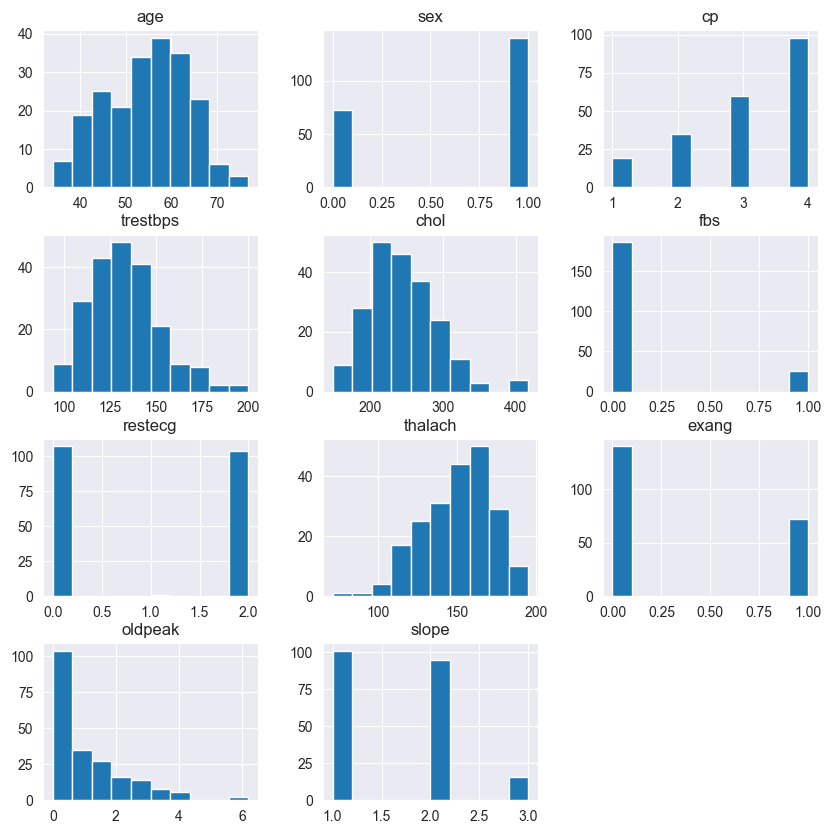

In [6]:
df.hist(figsize=(10,10))

Restecg looks strange as if there were no values 1. Let's check it:

In [7]:
df['restecg'].value_counts()

restecg
0    107
2    104
1      1
Name: count, dtype: int64

There is only one value 1, so we will treat it as an outlier.

<Axes: >

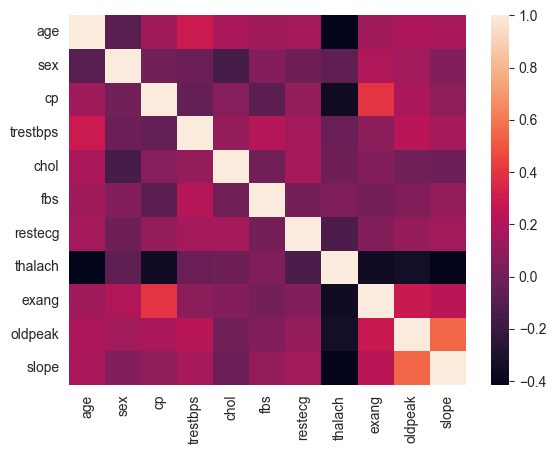

In [8]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns? Also, there is negative correlation between thalach and: age, cp, exang, oldpeak, slope.

In [9]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")
print(f"thalach and age correlation: {df[['thalach', 'age']].corr().iloc[0,1]}")
print(f"thalach and slope correlation: {df[['thalach', 'slope']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5458278072906251
cp and exang correlation: 0.39916290470356114
thalach and age correlation: -0.4149739322362583
thalach and slope correlation: -0.40644733868269406


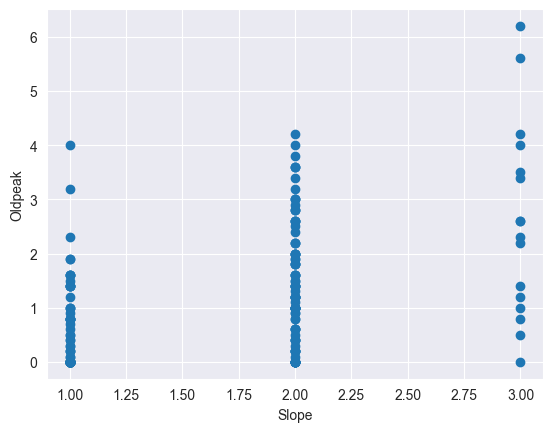

In [10]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

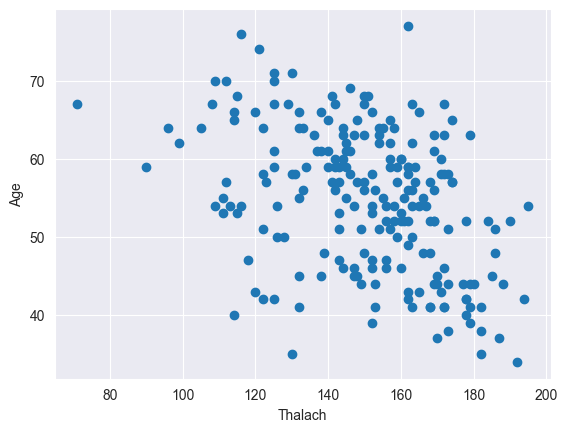

In [11]:
plt.scatter(df['thalach'], df['age'])
plt.xlabel('Thalach')
plt.ylabel('Age')
plt.show()

In [12]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [13]:
calc_vif(df)

,variables,VIF
0,age,39.346948
1,sex,3.095046
2,cp,12.426015
3,trestbps,58.483209
4,chol,29.128519
5,fbs,1.200710
6,restecg,2.136638
7,thalach,34.543369
8,exang,2.081073
9,oldpeak,2.720192


Which variables should we drop? According to traditional correlation between variables it could be slope, but after calculating VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables. So from both methods thalach column is a candidate to delete.

## Preprocessing

In [14]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound

    value = data['restecg'].value_counts().idxmax()
    data['restecg'] = data['restecg'].replace(1, value)
    data['restecg'] = data['restecg'].replace(2, 1) # make restecg a boolean column: 1 means hypertrophy, 0 is normal

    return data

In [15]:
#  Encode chest pain type column
def encode_columns(data):
    """
        Encodes categorical column cp (chest pain type)

    :param data: Dataframe
    :return: Encoded dataframe
    """
    data = pd.get_dummies(data, columns=['cp'], prefix='cp', dtype=int)
    data = data.rename(columns={"cp_1": "cp_typ_ang", "cp_2": "cp_atyp_ang", "cp_3": "cp_non_ang", "cp_4": "cp_asympt"})
    return data

In [16]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it. We will test it later.

In [17]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

In [18]:
# Let's check our functions
df_prep = replace_outliers(raw_data)
df_prep = encode_columns(df_prep)
df_prep

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,65.0,1,138.00,282.0,1,1,174.0,0,1.4,2,1,0,0,0
1,62.0,1,120.00,267.0,0,0,99.0,1,1.8,2,0,0,0,1
2,57.0,1,150.00,168.0,0,0,174.0,0,1.6,1,0,0,1,0
3,57.0,1,140.00,192.0,0,0,148.0,0,0.4,2,0,0,0,1
4,58.0,0,100.00,248.0,0,1,122.0,0,1.0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,54.0,1,171.25,283.0,0,1,195.0,0,0.0,1,0,1,0,0
208,67.0,1,125.00,254.0,1,0,163.0,0,0.2,2,0,0,0,1
209,59.0,1,140.00,177.0,0,0,162.0,1,0.0,1,0,0,0,1
210,61.0,1,140.00,207.0,0,1,138.0,1,1.9,1,0,0,0,1


In [19]:
minmax(df_prep)

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,0.720930,1.0,0.569579,0.617169,1.0,1.0,0.793103,0.0,0.350,0.5,1.0,0.0,0.0,0.0
1,0.651163,1.0,0.336570,0.547564,0.0,0.0,0.054187,1.0,0.450,0.5,0.0,0.0,0.0,1.0
2,0.534884,1.0,0.724919,0.088167,0.0,0.0,0.793103,0.0,0.400,0.0,0.0,0.0,1.0,0.0
3,0.534884,1.0,0.595469,0.199536,0.0,0.0,0.536946,0.0,0.100,0.5,0.0,0.0,0.0,1.0
4,0.558140,0.0,0.077670,0.459397,0.0,1.0,0.280788,0.0,0.250,0.5,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.465116,1.0,1.000000,0.621810,0.0,1.0,1.000000,0.0,0.000,0.0,0.0,1.0,0.0,0.0
208,0.767442,1.0,0.401294,0.487239,1.0,0.0,0.684729,0.0,0.050,0.5,0.0,0.0,0.0,1.0
209,0.581395,1.0,0.595469,0.129930,0.0,0.0,0.674877,1.0,0.000,0.0,0.0,0.0,0.0,1.0
210,0.627907,1.0,0.595469,0.269142,0.0,1.0,0.438424,1.0,0.475,0.0,0.0,0.0,0.0,1.0


## Number of clusters

In [20]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from preprocessing import standarize, minmax, normalize, replace_outliers, preprocessing
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [21]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [22]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 10):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 10), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

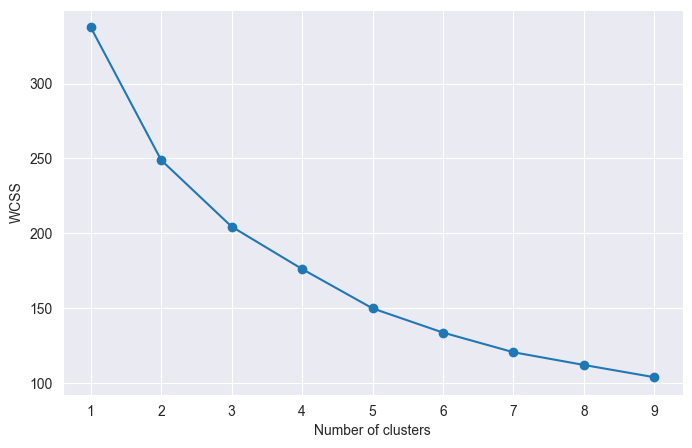

Elbow method: 2


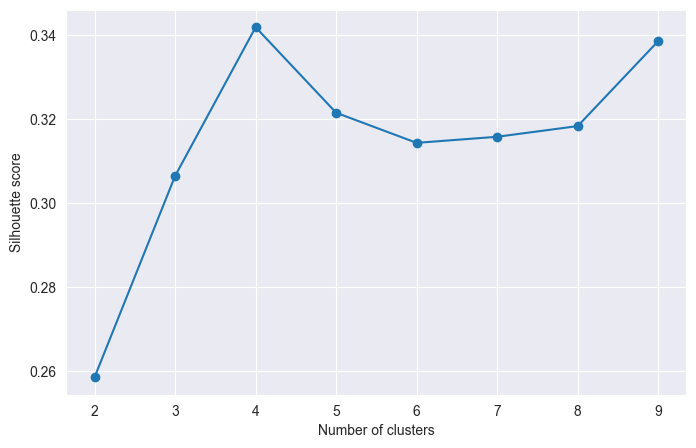

Silhouette method: 4


In [23]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = encode_columns(df_clusters)
df_clusters = minmax(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we can test it on a baseline model:

In [24]:
for i in [2,4]:
    dfkmeans, model = k_means_alg(df_clusters, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

number of clusters: 2
silhouette score: 0.2585127764435932
calinski harabasz score: 74.91359294200848
davies bouldin score: 1.6144536506981688
number of clusters: 4
silhouette score: 0.34189593924075024
calinski harabasz score: 63.61462617281558
davies bouldin score: 1.1871561668138637


We can see that results are better for 4 clusters. Now let's check how preprocessing influences clusters and score.

In [25]:
processing = ['stand', 'minmax', 'norm']
for proc in processing:
    print(f'Processing: {proc}')
    df_proc = preprocessing(raw_data, rem_over=False, process=proc)
    dfkmeans, model = k_means_alg(df_proc, num_clusters=4)
    y = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_proc, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_proc, y)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_proc, y)}")

Processing: stand
number of clusters: 4
silhouette score: 0.23173632823786422
calinski harabasz score: 39.82012531332847
davies bouldin score: 1.5603427916271144
Processing: minmax
number of clusters: 4
silhouette score: 0.34189593924075024
calinski harabasz score: 63.61462617281558
davies bouldin score: 1.1871561668138637
Processing: norm
number of clusters: 4
silhouette score: 0.3013915070161222
calinski harabasz score: 138.6713157984871
davies bouldin score: 0.9719207238716615


Results vary depending on processing used. Normalizer has the best results, but we can see that normalized data is hard to interpret:

In [26]:
normalize(raw_data).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.178181,0.002741,0.002741,0.378291,0.773029,0.002741,0.0,0.476976,0.000000,0.003838,0.005482
1,0.196692,0.003172,0.012690,0.380695,0.847046,0.000000,0.0,0.314073,0.003172,0.005710,0.006345
2,0.196362,0.003445,0.010335,0.516742,0.578751,0.000000,0.0,0.599421,0.000000,0.005512,0.003445
3,0.199493,0.003500,0.014000,0.489983,0.671977,0.000000,0.0,0.517983,0.000000,0.001400,0.007000
4,0.193578,0.000000,0.013350,0.333755,0.827711,0.000000,0.0,0.407180,0.000000,0.003338,0.006675


For example values in sex column are around 0.003 while in chol or thalach values are way bigger. Thus, minmax scaler is the most reasonable scaler.

In [27]:
df_minmax = preprocessing(raw_data, rem_over=False, process='minmax')
for i in [2, 3, 4, 5, 6]:
    dfkmeans, _ = k_means_alg(df_minmax, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_minmax, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_minmax, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_minmax, y_kmeans)}")

number of clusters: 2
silhouette score: 0.2585127764435932
calinski harabasz score: 74.91359294200848
davies bouldin score: 1.6144536506981688
number of clusters: 3
silhouette score: 0.3064631957715616
calinski harabasz score: 68.11723017417114
davies bouldin score: 1.533569836390311
number of clusters: 4
silhouette score: 0.34189593924075024
calinski harabasz score: 63.61462617281558
davies bouldin score: 1.1871561668138637
number of clusters: 5
silhouette score: 0.32151995607041045
calinski harabasz score: 64.90508564756958
davies bouldin score: 1.287536387083117
number of clusters: 6
silhouette score: 0.3143465846027279
calinski harabasz score: 62.92517760487492
davies bouldin score: 1.2955589595073556


On average the more clusters the better the results, but we have to draw a line somewhere and pick apropriate number of clusters (4 looks the best). Last question is if we should use PCA for reducing dimensionality.

In [28]:
df_pca = preprocessing(raw_data, process='stand')
dfkmeans, model = k_means_alg(df_pca, num_clusters=4)
y_kmeans = dfkmeans['label']
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

number of clusters: 4
silhouette score: 0.24032466105323663
calinski harabasz score: 41.672726295878306
davies bouldin score: 1.5218206964882923


The scores are way worse. Maybe it is easier to visualize clustering as we only have 3 variables, but we lose interpretability which is crucial in medical data analysis. That said in preprocessing we will stick to minmax scaler and outliers removal, and we will be using 4 clusters.

## Algorithms

In [29]:
from metrices import metrices
from OtherAlgorithms import medians_for_clusters, dbscan
from preprocessing import preprocessing
from KMeans import k_means_alg

### Kmeans

In [31]:
df_kmeans = preprocessing(raw_data, rem_over=False, process='minmax')
df_kmeans, model = k_means_alg(df_kmeans, num_clusters=4)
df_kmeans_no_labels = df_kmeans.drop("label", axis=1)
y_kmeans = df_kmeans['label']
for metric in metrices:
    print(f'{metric}: {metrices[metric](df_kmeans_no_labels, y_kmeans)}')

number of clusters: 4
Minimal distance between clusters: 1.4145219177518047
Average distance between points in the same class: 1.212957118748629
Standard deviation of distance between points in the same class: 0.0792356150062923
Silhouette: 0.34189593924075024
calinski_harabasz_score: 63.61462617281558
davies_bouldin_score: 1.1871561668138637


### DBSCAN

In [32]:
df = preprocessing(raw_data, rem_over=True, process='minmax')
df_with_labels, model = dbscan(df, 'minmax')
df_without_labels = df_with_labels.drop("label", axis=1)
y = df_with_labels['label']
for metric in metrices:
    print(f'{metric}: {metrices[metric](df_without_labels, y)}')
data_with_labels = raw_data
data_with_labels['label'] = df_with_labels['label']
print(medians_for_clusters(data_with_labels))

Minimal distance between clusters: 0.5127120795590524
Average distance between points in the same class: 0.6780062826349265
Standard deviation of distance between points in the same class: 0.37612405978311
Silhouette: 0.31453422430198
calinski_harabasz_score: 31.776258119192825
davies_bouldin_score: 1.4471560845350817
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak   
label                                                                           
-1     59.0  1.0  3.0     142.0  231.0  0.0      0.0    156.0    0.0     1.20  \
 0     57.0  1.0  4.0     129.0  257.0  0.0      0.0    130.0    1.0     1.80   
 1     52.0  1.0  3.0     132.0  232.0  0.0      0.0    162.0    0.0     0.40   
 2     51.0  1.0  4.0     123.0  233.5  0.0      0.0    150.5    0.0     0.45   
 3     60.5  0.0  4.0     129.0  256.0  0.0      0.0    150.0    0.0     0.50   
 4     52.0  1.0  4.0     128.0  230.0  1.0      0.0    156.0    1.0     1.00   
 5     54.0  0.0  3.0     129.0 